In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pathlib

In [3]:
path = pathlib.Path(os.path.normpath('C:/Users/shruti/Deep_learning_projects/Cat Dog classifier/'))
path

WindowsPath('C:/Users/shruti/Deep_learning_projects/Cat Dog classifier')

#### LOADING DATA

In [4]:
train_path = path/'dataset/training_set'
test_path = path/'dataset/test_set'

In [5]:
transform = transforms.Compose([transforms.Resize((240,240)),
                              transforms.ToTensor(),
                              transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])


In [6]:
#loading the dataset folder
train = datasets.ImageFolder(train_path, transform = transform)
test = datasets.ImageFolder(test_path, transform = transform)

In [7]:
#loading the dataset
batch_size = 4
train_set = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle=True)
val_set = torch.utils.data.DataLoader(test, batch_size=batch_size,shuffle=True)

In [8]:
#defining the classes
classes = ('cat', 'dog')

In [9]:
#using gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

#### VISUALIZING THE DATA

In [10]:
def imshow(inp, title = None):
    image = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image*std + mean
    image = np.clip(image, 0,1)
    plt.imshow(image)
    if title is not None:
        print(title)
    plt.pause(0.001)     #pause a bit so that the plots are updated

['dog', 'dog', 'dog', 'cat']


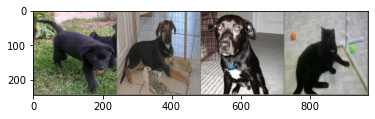

In [11]:
#getting a batch of training data
images, labels = next(iter(train_set))
out = torchvision.utils.make_grid(images)
imshow(out,title=[classes[x] for x in labels])

dog


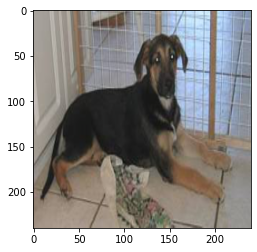

In [12]:
#displaying 1 picture
imshow(images[1], title=classes[labels[1]])

#### TRAINING OUR MODEL

fine tuning a model 

In [13]:
def train_model(train_val, model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        print("-"*10)
        
        model.train()
    
        running_loss = 0.0
        running_correct = 0
        total=0
        

        #iterate over the data
        for images, labels in train_set:
            images = images.to(device)
            labels = labels.to(device)
            
            #zero the parameter gradient
            optimizer.zero_grad()
            
            #forward pass and track the history if we are training
            #with torch.set_grad_enabled(True):
            output = model(images)
            _, predicted = torch.max(output, 1)
            loss = criterion(output, labels)
            
                    #backprop and optimize
            loss.backward()
            optimizer.step()
            
            #statistics
            running_loss+=loss.item()*images.size(0)
            running_correct+=torch.sum(predicted==labels.data)
            total+=labels.size(0)
            
        
        scheduler.step()   #change learning rate
        
        epoch_loss = running_loss/len(train_set)
        #epoch_acc = running_correct.double()/len(train_set)
        epoch_acc = running_correct.double()/total
        print("Loss: {:.4f}        Acc: {:.4f}".format(epoch_loss, epoch_acc))
        print()
             
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    
    return model

In [14]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_set,):
            images = images.to(device)
            labels = labels.to(device)
            
            output = model(images)
            _,pred = torch.max(output, 1)
            
            for i in range(images.size()[0]):
                images_so_far+=1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title("predicted: {}".format(classes[pred[i]]))
                imshow(images.cpu().data[i])
                
                if images_so_far==num_images:
                    model.train(mode=was_training)
                    return
            model.train(mode=was_training)

#### FINETUNING THE MODEL

In [15]:
model = models.resnet18(pretrained=True)
num_filters = model.fc.in_features
model.fc = nn.Linear(num_filters, len(classes))
#we are just changing the last layer to give as a desired output with 2 classes here

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum =0.9)

scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma=0.1)

In [26]:
model = train_model('train', model, criterion, optimizer, scheduler,num_epochs=10)

Epoch 1/10
----------
Loss: 1.3437        Acc: 0.8811

Epoch 2/10
----------
Loss: 0.3541        Acc: 0.9667

Epoch 3/10
----------
Loss: 0.1676        Acc: 0.9863

Epoch 4/10
----------
Loss: 0.0933        Acc: 0.9920

Epoch 5/10
----------
Loss: 0.0838        Acc: 0.9925

Epoch 6/10
----------
Loss: 0.0504        Acc: 0.9965

Epoch 7/10
----------
Loss: 0.0700        Acc: 0.9940

Epoch 8/10
----------
Loss: 0.0218        Acc: 0.9992

Epoch 9/10
----------
Loss: 0.0156        Acc: 0.9992

Epoch 10/10
----------
Loss: 0.0106        Acc: 0.9995

Training complete in 92m 57s


#### SAVING OUR MODEL WEIGHTS

In [27]:
save_path = "./finetuning_model"
torch.save(model.state_dict(), save_path)

In [18]:
save_path = "./finetuning_model"
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [19]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### VALIDATING OUR MODEL

In [20]:
correct = 0.0
total = 0.0
with torch.no_grad():
    for (images, labels) in val_set:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        _,predicted = torch.max(output, 1)
        correct+=torch.sum(predicted==labels.data)
        total+=labels.size(0)
print("The validation acc: {:.4f}".format(correct/total))

The validation acc: 0.9840


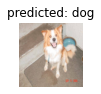

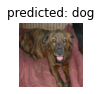

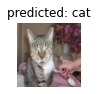

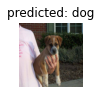

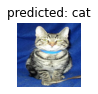

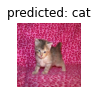

In [21]:
visualize_model(model)

#### ACCURACY OF EACH CLASS

In [24]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for data in val_set:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of   cat : 99 %
Accuracy of   dog : 97 %
